In [30]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt


In [100]:
df_data = pd.read_csv('data.csv')
df_data.head()

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

             offer  conversion  
0  Buy One Get One           0  
1         No Offer           0  
2  Buy One Get One           0  
3         Discount           0  
4  Buy One Get One           0

In [101]:
df_data.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df_data.head()

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

         treatment  target  
0  Buy One Get One       0  
1         No Offer       0  
2  Buy One Get One       0  
3         Discount       0  
4  Buy One Get One       0

In [102]:
df_data['treatment'] = np.where(df_data['treatment'] == 'No Offer', 0, 1)
df_data['treatment'].unique()

array([1, 0])

### feature engineering ###

In [103]:
df_data.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
treatment          int64
target             int64
dtype: object

In [104]:
df_data.history.describe()

count    64000.000000
mean       242.085656
std        256.158608
min         29.990000
25%         64.660000
50%        158.110000
75%        325.657500
max       3345.930000
Name: history, dtype: float64

In [105]:
df_data.zip_code.unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [106]:
df_data.channel.unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

In [107]:
cat_features = ['zip_code', 'channel']
encode_columns = pd.get_dummies(df_data[cat_features])

In [108]:
df_data = df_data.join(encode_columns).drop(cat_features, axis=1)

In [109]:
df_data.head(5)

recency  history  used_discount  used_bogo  is_referral  treatment  target  \
0       10   142.44              1          0            0          1       0   
1        6   329.08              1          1            1          0       0   
2        7   180.65              0          1            1          1       0   
3        9   675.83              1          0            1          1       0   
4        2    45.34              1          0            0          1       0   

   zip_code_Rural  zip_code_Surburban  zip_code_Urban  channel_Multichannel  \
0               0                   1               0                     0   
1               1                   0               0                     0   
2               0                   1               0                     0   
3               1                   0               0                     0   
4               0                   0               1                     0   

   channel_Phone  channel_Web  
0              1            0  
1              0            1  
2              0            1  
3              0            1  
4              0            1

### Разделение на train и test 

In [110]:
dataset = df_data.drop(columns=['treatment', 'target'])
target = df_data['target']
treatment = df_data['treatment']

In [111]:
X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(dataset, 
                                                                          target, 
                                                                          treatment, 
                                                                          test_size=0.3, random_state=42)

In [112]:
models_results = {
    'approach': [],
    'uplift@20%': [],
    'uplift@10%': []
}

In [113]:
# !pip install scikit-uplift==0.2.0

### Одна модель с признаком коммуникации

In [114]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('SoloModel')
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@10%'].append(sm_score_10)

### Трансформация классов

In [115]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@10%'].append(ct_score_10)


<ipython-input-115-66332083626c>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train)


### Две независимые модели

In [116]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_val)

tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@10%'].append(tm_score_10)


In [117]:
pd.DataFrame(data=models_results)

approach  uplift@20%  uplift@10%
0            SoloModel    0.084570    0.102578
1  ClassTransformation    0.095181    0.101838
2            TwoModels    0.081051    0.083775

In [130]:
features = [col for col in X_train]

CPU times: user 3.42 s, sys: 324 ms, total: 3.75 s
Wall time: 8.79 s


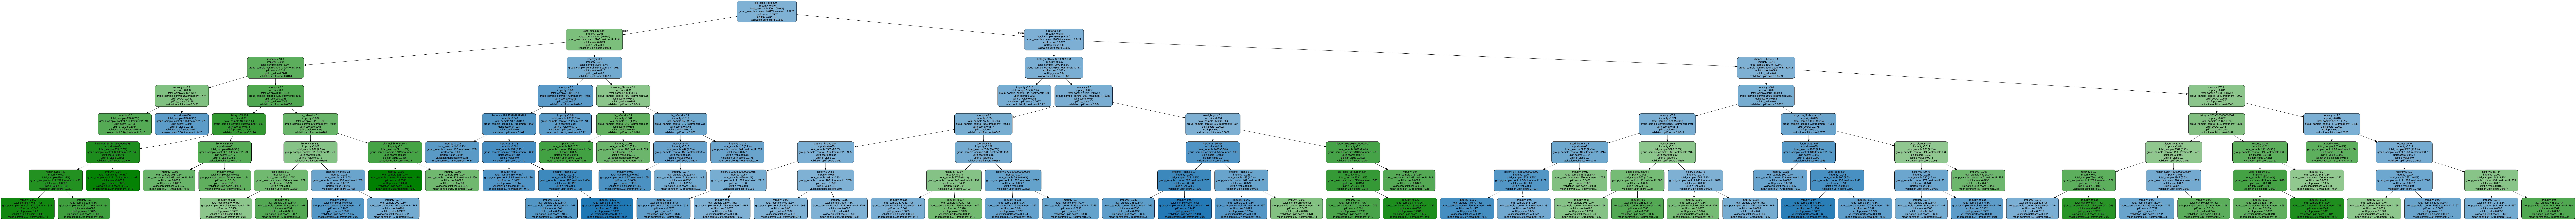

In [132]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())